In [111]:
import random
import math
from tqdm import tqdm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
import thinkbayes
import thinkplot


class Height(thinkbayes.Suite,thinkbayes.Joint):
    def __init__(self,mus,sigmas):
        pmf=thinkbayes.Pmf()
        for mu,sigma in [(mu,sigma) for mu in mus for sigma in sigmas]:
            pmf.Set((mu,sigma),1)
        pmf.Normalize()
        thinkbayes.Suite.__init__(self,pmf)
    
    # original update
    def UpdateSet(self,dataset):
        for data in tqdm(dataset):
            for hypo in self.Values():
                x=data
                mu,sigma=hypo
                like=thinkbayes.EvalGaussianPdf(x,mu,sigma)
                self.Mult(hypo, like)
        return self.Normalize()
    
    # log likelihood update
    def LogUpdateSet(self,dataset):
        for data in tqdm(dataset):
            for hypo in self.Values():
                x=data
                mu,sigma=hypo
                loglike=scipy.stats.norm.logpdf(x,mu,sigma)
                self.Incr(hypo,loglike)
        
    # approximate bayes calculation
    def LogUpdateSetABC(self,dataset):
        xs=dataset
        n=len(xs)
        m=np.mean(xs)
        s=np.std(xs)
        for hypo in sorted(self.Values()):
            mu,sigma=hypo
            # assume mu and sigma belong to Gaussian distribution to avoid iterating all data points
            mean_loglike=scipy.stats.norm.logpdf(m,mu,sigma/math.sqrt(n))
            std_loglike=scipy.stats.norm.logpdf(s,sigma,sigma*math.sqrt(2*(n-1)))
            loglike=mean_loglike+std_loglike
            self.Incr(hypo,loglike)

## Coefficient variation function used in book

In [52]:
def CoefVariation(suite):
    pmf=thinkbayes.Pmf()
    for (mu,sigma),p in suite.Items():
        pmf.Incr(sigma/mu,p)
    return pmf

## Effect size function for ex10-1

In [132]:
def EffectSize(suite1,suite2):
    pmf=thinkbayes.Pmf()
    v1=sorted([(v,p)for v,p in suite1.Items()],key=lambda x:x[1])
    v2=sorted([(v,p)for v,p in suite2.Items()],key=lambda x:x[1])
    n1=len(v1)
    n2=len(v2)
    for i in range(1000):
        (mu1,sigma1),p1=v1[random.randint(0,n1-1)]
        (mu2,sigma2),p2=v2[random.randint(0,n2-1)]
        effect_size=2*(mu1-mu2)/(sigma1+sigma2)
        pmf.Set(effect_size,p1*p2)
    pmf.Normalize()
    return pmf

## Process trivially
Update without log likelihood. Using CV as criteria.

In [88]:
def Process(dataset):
    # get mu & sigma prior range
    m=np.mean(dataset)  # mean
    s=np.std(dataset)  # std
    n=len(dataset)
    stderr_m=s/math.sqrt(n)  # satndard error of mean
    stderr_s=s/(math.sqrt(2*(n-1)))  # standard error of std
    mu_range=np.linspace(m-3*stderr_m,m+3*stderr_m,30)
    sigma_range=np.linspace(s-3*stderr_s,s+3*stderr_s,30)
    
    # update
    suite=Height(mus=mu_range,sigmas=sigma_range)
    suite.UpdateSet(dataset)
    return suite


100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

 56%|█████▌    | 56/100 [00:08<00:06,  6.91it/s]


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


(163.57692033540388, 6.910839710104065)
(177.01259919112078, 7.330177444214526)


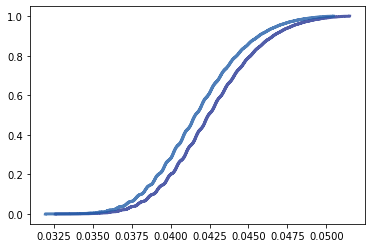

In [89]:
dataset_female=np.random.normal(163,7.3,size=100)
dataset_male=np.random.normal(178,7.7,size=100)
suite_f=Process(dataset_female)
suite_m=Process(dataset_male)
print(suite_f.MaximumLikelihood())
print(suite_m.MaximumLikelihood())
cv_f=CoefVariation(suite_f)
cv_m=CoefVariation(suite_m)
cdf_cv_f=cv_f.MakeCdf()
cdf_cv_m=cv_m.MakeCdf()
thinkplot.Cdfs([cdf_cv_f,cdf_cv_m])

Conclusion: Female dataset has larger CV.

## Compare algorithms

### Trivial update: underflow

In [84]:
import time

def NumUnderflow(suite):
    under=0
    for v,p in suite.Items():
        if not p:
            under+=1
            print(v,p)
    print("zero probability point: {}".format(under))

In [85]:
# on small dataset: no underflow
dataset=np.random.normal(163,7.3,size=100)
start_t=time.time()
suite=Process(dataset)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset)))
print(NumUnderflow(suite))


100%|██████████| 100/100 [00:06<00:00, 16.57it/s]

time cost per data: 0.0010074273347854615
zero probability point: 0
None


In [90]:
# on large dataset: underflow
dataset=np.random.normal(163,7.3,size=500)
start_t=time.time()
suite=Process(dataset)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset)))
print(NumUnderflow(suite))


 31%|███       | 155/500 [00:22<01:00,  5.70it/s]


 62%|██████▏   | 309/500 [00:42<00:24,  7.85it/s]


 93%|█████████▎| 463/500 [01:01<00:04,  7.83it/s]


100%|██████████| 500/500 [01:05<00:00,  7.58it/s]


ValueError: total probability is zero.

Conclusion: with large dataset, trivial update causes underflow.

### Log likelihood update: no underflow

In [94]:
def ProcessWithLog(dataset):
    # get mu & sigma prior range
    m=np.mean(dataset)  # mean
    s=np.std(dataset)  # std
    n=len(dataset)
    stderr_m=s/math.sqrt(n)  # satndard error of mean
    stderr_s=s/(math.sqrt(2*(n-1)))  # standard error of std
    mu_range=np.linspace(m-3*stderr_m,m+3*stderr_m,30)
    sigma_range=np.linspace(s-3*stderr_s,s+3*stderr_s,30)
    
    # update by data
    suite=Height(mus=mu_range,sigmas=sigma_range)
    suite.Log()
    suite.LogUpdateSet(dataset)
    suite.Exp()

    return suite

In [97]:
# on large dataset: no underflow
dataset=np.random.normal(163,7.3,size=500)
start_t=time.time()
suite=ProcessWithLog(dataset)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset)))
print(NumUnderflow(suite))


 31%|███       | 155/500 [00:23<00:51,  6.66it/s]


 62%|██████▏   | 309/500 [00:45<00:27,  6.98it/s]


 93%|█████████▎| 463/500 [01:08<00:06,  5.61it/s]


100%|██████████| 500/500 [01:13<00:00,  6.77it/s]

time cost per data: 0.0024621994654337566
zero probability point: 0
None


Conclusion: underflow does not happen using log likelihood.


 31%|███       | 155/500 [00:24<00:52,  6.61it/s]


 62%|██████▏   | 309/500 [00:47<00:31,  6.05it/s]


 93%|█████████▎| 463/500 [01:09<00:05,  6.79it/s]


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

time cost per data: 0.0025046599626541138



 31%|███       | 156/500 [00:21<00:46,  7.44it/s]


 62%|██████▏   | 310/500 [00:43<00:25,  7.43it/s]


 93%|█████████▎| 464/500 [01:06<00:05,  6.96it/s]


100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


time cost per data: 0.002402537067731222
(162.64726953511172, 7.233935064805859)
(178.80326614281992, 7.71716742519496)


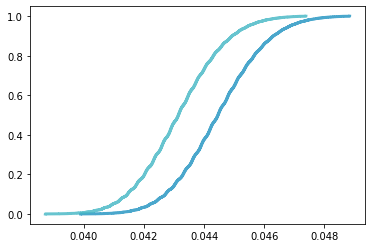

In [95]:
# plot result of large dataset
dataset_female=np.random.normal(163,7.3,size=500)
dataset_male=np.random.normal(178,7.7,size=500)
start_t=time.time()
suite_f=ProcessWithLog(dataset_female)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_female)))
start_t=time.time()
suite_m=ProcessWithLog(dataset_male)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_male)))
print(suite_f.MaximumLikelihood())
print(suite_m.MaximumLikelihood())
cv_f=CoefVariation(suite_f)
cv_m=CoefVariation(suite_m)
cdf_cv_f=cv_f.MakeCdf()
cdf_cv_m=cv_m.MakeCdf()
thinkplot.Cdfs([cdf_cv_f,cdf_cv_m])

### Update with log likelihood ABC: faster

In [119]:
def ProcessWithLogABC(dataset):
    # get mu & sigma prior range
    m=np.mean(dataset)  # mean
    s=np.std(dataset)  # std
    n=len(dataset)
    stderr_m=s/math.sqrt(n)  # satndard error of mean
    stderr_s=s/(math.sqrt(2*(n-1)))  # standard error of std
    mu_range=np.linspace(m-3*stderr_m,m+3*stderr_m,20)
    sigma_range=np.linspace(s-3*stderr_s,s+3*stderr_s,20)
    
    # update by data
    suite=Height(mus=mu_range,sigmas=sigma_range)
    suite.Log()
    suite.LogUpdateSetABC(dataset)
    suite.Exp()
    suite.Normalize()
    
    return suite

time cost per data: 5.2132368087768554e-06
time cost per data: 3.568601608276367e-06
(162.47215808123207, 6.210922999590021)
(178.58621224763797, 6.897467382890723)


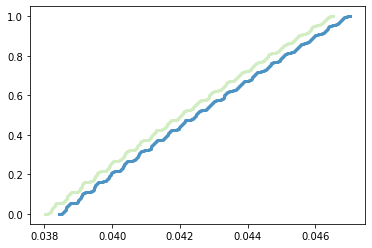

In [120]:
dataset_female=np.random.normal(163,7.3,size=500)
dataset_male=np.random.normal(178,7.7,size=500)
start_t=time.time()
suite_f=ProcessWithLogABC(dataset_female)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_female)))
start_t=time.time()
suite_m=ProcessWithLogABC(dataset_male)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_male)))
print(suite_f.MaximumLikelihood())
print(suite_m.MaximumLikelihood())
cv_f=CoefVariation(suite_f)
cv_m=CoefVariation(suite_m)
cdf_cv_f=cv_f.MakeCdf()
cdf_cv_m=cv_m.MakeCdf()
thinkplot.Cdfs([cdf_cv_f,cdf_cv_m])

Conclusion: ABC avoid iterating all data points when updating, rather, it uses their statistics. So it is faster.

## Answer to ex10-1: Using effect size
Update with log likelihood and ABC. Using effect size as criteria.

time cost per data: 4.3231328328450516e-06
time cost per data: 3.672027587890625e-06
(162.76654294633346, 6.7690475584424945)
(178.04383087577762, 6.820374072748746)


{'xscale': 'linear', 'yscale': 'linear'}

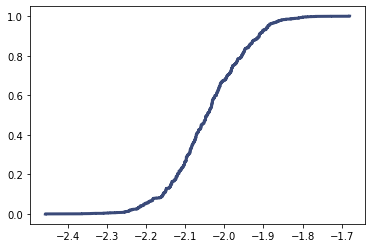

In [133]:
dataset_female=np.random.normal(163,7.3,size=500)
dataset_male=np.random.normal(178,7.7,size=500)
start_t=time.time()
suite_f=ProcessWithLogABC(dataset_female)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_female)))
start_t=time.time()
suite_m=ProcessWithLogABC(dataset_male)
print("time cost per data: {}".format((time.time()-start_t)/60/len(dataset_male)))
print(suite_f.MaximumLikelihood())
print(suite_m.MaximumLikelihood())
es=EffectSize(suite_f,suite_m)
cdf_es=es.MakeCdf()
thinkplot.Cdf(cdf_es)

Conclusion: the effect size <0, so female has larger difference.